In [76]:
import pandas as pd
import tensorflow as tf
import transformers
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm
import pickle
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [77]:
background = '#D7E5E5'
mpl.rcParams['font.family']= 'Candara'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['legend.title_fontsize'] = 10
mpl.rcParams['savefig.facecolor']='white'
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['axes.labelweight'] = 'heavy'

In [49]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [50]:
pd.set_option('display.max_colwidth', None)

In [51]:
df = pd.read_csv('../input/redditflairdataset/final_dataset.csv', index_col=0)

In [52]:
df

,title,flair
0,India to prepare digital maps of all villages The Hindu,Policy/Economy
1,youtube channels critical to UP govt were deleted,Politics
2,Father just passed away,Non-Political
3,I am in class 11 th preparing for JEE Advanced and I am unable to understand current chapters,AskIndia
4,Understanding CFI Linked to Hijab Row Is It Voice of The Marginalised Or A Megaphone for Mischief,Politics
...,...,...
164086,Anyone here preparing for the RBI Grade B exams this year We can create something like a study group subreddit if anyone is interested,AskIndia
164087,Bombay HC raps Maharashtra govt for failing to provide safe public toilets for women,Politics
164088,What are the awesome places to go for a single person in or near Bangalore for a single day,AskIndia
164089,Guess who,Non-Political


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164091 entries, 0 to 164090
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   163650 non-null  object
 1   flair   164091 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


In [54]:
# sr = pd.isnull(df['full_text'])
sr = pd.isnull(df['title'])
drop_arr = sr.loc[sr==True].index.tolist()
df.drop(drop_arr, axis=0, inplace=True)
df = df.reset_index(drop=True)

In [55]:
df.drop(df[df['flair']=='Non-Political'].index, inplace=True)

<AxesSubplot:ylabel='flair'>

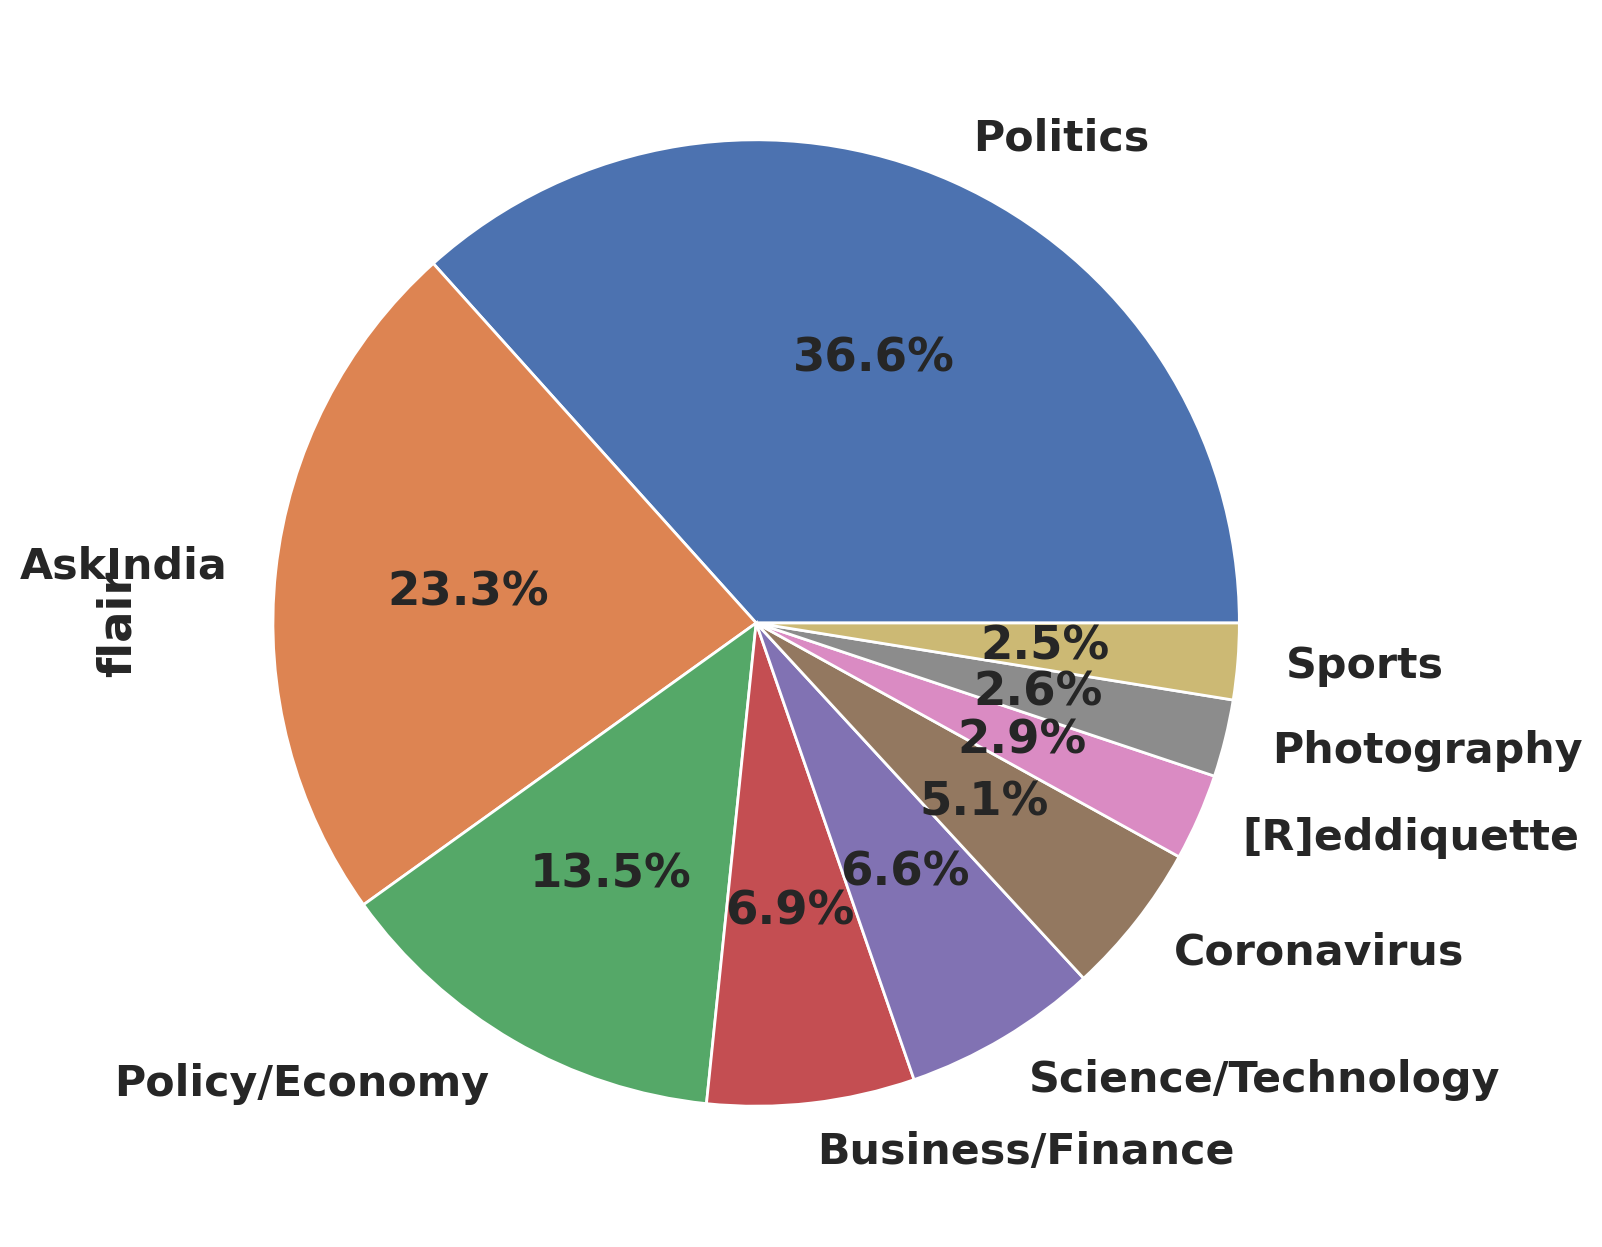

In [92]:
fig = plt.figure(figsize=(12, 8))
fig.set_dpi(200)
d = df['flair'].value_counts()
d.plot.pie(autopct='%1.1f%%')

In [93]:
fig.savefig('./class.png', dpi=1000, bbox_inches='tight')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116308 entries, 0 to 163647
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   116308 non-null  object
 1   flair   116308 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


Text(0, 0.5, 'Count of samples')

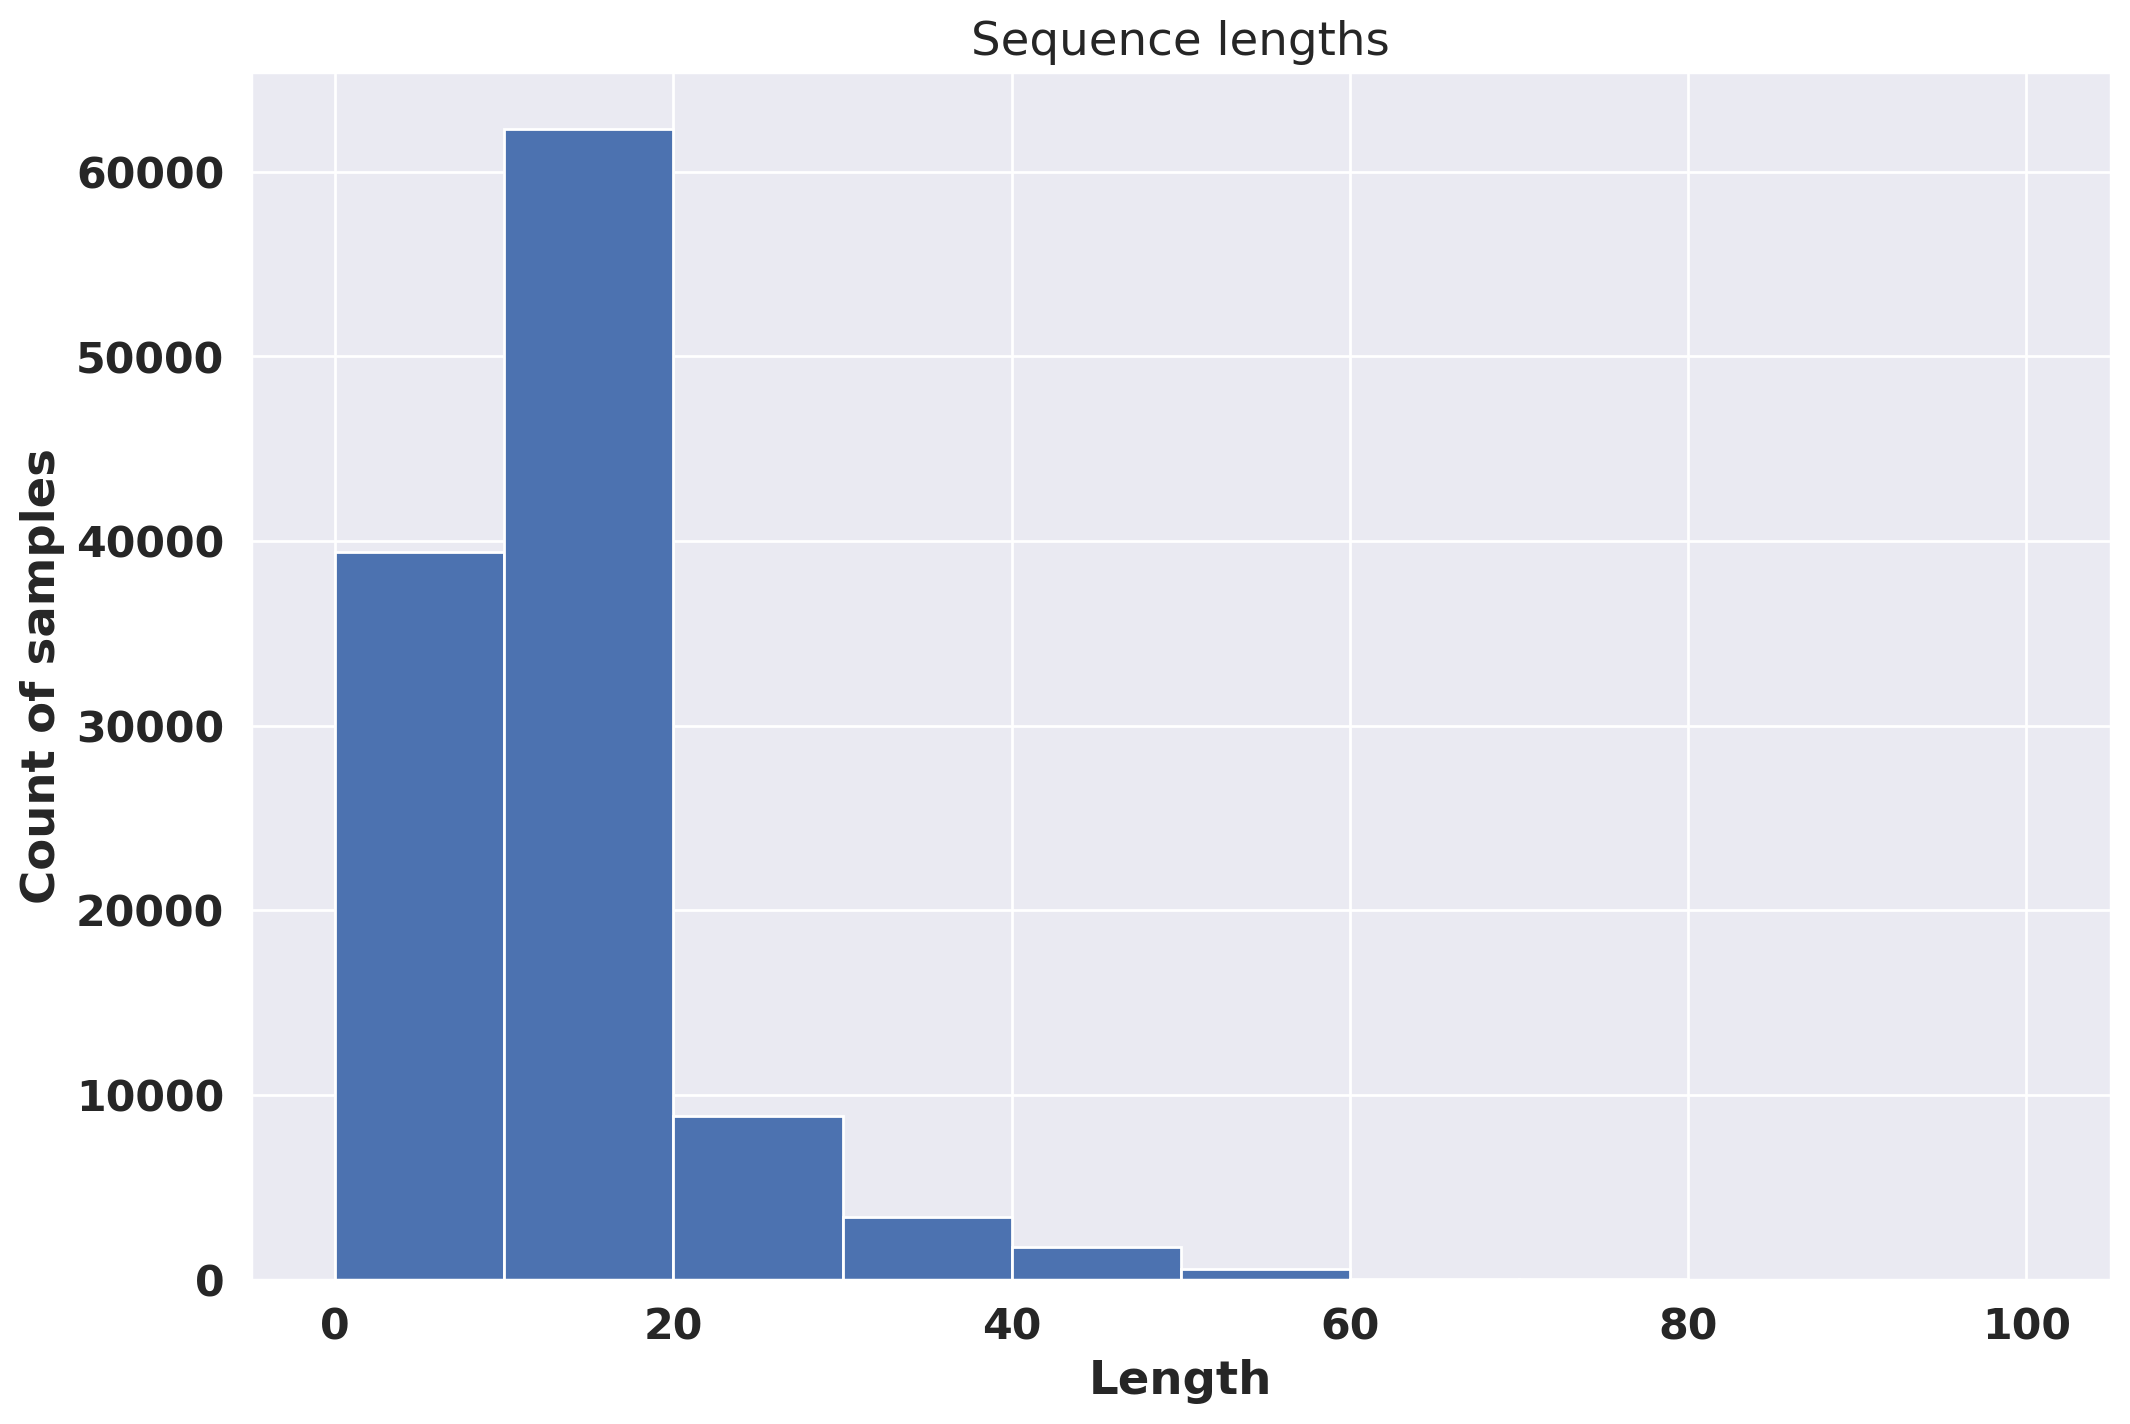

In [95]:
fig = plt.figure(figsize=(12, 8))
fig.set_dpi(200)
lengths = list(df.title.str.split().str.len())
plt.hist(lengths, range=(0, 100))
plt.title('Sequence lengths')
plt.xlabel('Length')
plt.ylabel('Count of samples')

In [96]:
fig.savefig('./seqlen.png', dpi=1000, bbox_inches='tight')

In [58]:
# MAX_SEQ_LEN = df.full_text.str.split().str.len().max()
MAX_SEQ_LEN = 50

In [59]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [60]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['flair'], test_size=0.2, stratify=df['flair'])

In [62]:
X_train.shape, X_test.shape

((93046,), (23262,))

In [63]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, X_train, max_seq_length=MAX_SEQ_LEN)
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, X_test, max_seq_length=MAX_SEQ_LEN)

Converting docs to features: 100%|██████████| 23262/23262 [00:12<00:00, 1933.96it/s]


In [64]:
enc = OneHotEncoder()
train_labels_one_hot = enc.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
test_labels_one_hot = enc.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [65]:
train_labels_one_hot.shape, test_labels_one_hot.shape

((93046, 9), (23262, 9))

In [66]:
y_train

34672             AskIndia
42274     Business/Finance
139166       [R]eddiquette
81399             AskIndia
51934             Politics
                ...       
157653            Politics
33816             AskIndia
26133             Politics
114332      Policy/Economy
11672             AskIndia
Name: flair, Length: 93046, dtype: object

In [67]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced' , enc.categories_[0] , y_train)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['AskIndia' 'Business/Finance' 'Coronavirus' 'Photography'
 'Policy/Economy' 'Politics' 'Science/Technology' 'Sports' '[R]eddiquette'], y=34672             AskIndia
42274     Business/Finance
139166       [R]eddiquette
81399             AskIndia
51934             Politics
                ...       
157653            Politics
33816             AskIndia
26133             Politics
114332      Policy/Economy
11672             AskIndia
Name: flair, Length: 93046, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [68]:
class_weights

{0: 0.4777028206470957,
 1: 1.6013699573179128,
 2: 2.173768806653584,
 3: 4.298729498729498,
 4: 0.8258203086863523,
 5: 0.3031979718588904,
 6: 1.6956608896907404,
 7: 4.362212845757149,
 8: 3.8248037160356807}

In [69]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32', name="bert_input_1_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32', name="bert_input_1_masks")
inputs = [inp_id, inp_mask]

bert_layer = transformers.TFBertModel.from_pretrained('bert-base-cased')
for layer in bert_layer.layers:
    layer.trainable = False

hidden_state = bert_layer(inputs)[0]

pooled_output = hidden_state[:, 0]
dense1 = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.1)(dense2)
output = tf.keras.layers.Dense(9, activation='softmax')(drop2)

model = tf.keras.Model(inputs=[inp_id, inp_mask], outputs=output)
model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_1_ids (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_input_1_masks (InputLayer) [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 108310272   bert_input_1_ids[0][0]           
                                                                 bert_input_1_masks[0][0]         
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_bert_model_2[0][0]      

In [70]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [71]:
checkpoint_filepath = './'
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [72]:
# tf.optimizers.Adam(learning_rate=1e-3, epsilon=1e-08)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [73]:
history = model.fit([train_features_ids, train_features_masks], 
                    train_labels_one_hot, callbacks=[callback_lr, callback_model_checkpoint],
                    validation_split = 0.1, #class_weight=class_weights,
                    epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
655/655 [==============================] - 206s 294ms/step - loss: 1.3046 - accuracy: 0.5685 - auc_1: 0.8873 - val_loss: 1.1267 - val_accuracy: 0.6202 - val_auc_1: 0.9177
Epoch 2/20
655/655 [==============================] - 190s 290ms/step - loss: 1.1843 - accuracy: 0.6061 - auc_1: 0.9083 - val_loss: 1.0856 - val_accuracy: 0.6310 - val_auc_1: 0.9238
Epoch 3/20
655/655 [==============================] - 189s 289ms/step - loss: 1.1599 - accuracy: 0.6128 - auc_1: 0.9122 - val_loss: 1.0772 - val_accuracy: 0.6349 - val_auc_1: 0.9249
Epoch 4/20
655/655 [==============================] - 189s 289ms/step - loss: 1.1410 - accuracy: 0.6194 - auc_1: 0.9152 - val_loss: 1.0714 - val_accuracy: 0.6361 - val_auc_1: 0.9258
Epoch 5/20
655/655 [==============================] - 189s 288ms/step - loss: 1.1286 - accuracy: 0.6223 - auc_1: 0.9171 - val_loss: 1.0525 - val_accuracy: 0.6420 - val_auc_1: 0.9287
Epoch 6/20
655/655 [==============================] - 189s 288ms/step - loss: 1.1178 - acc

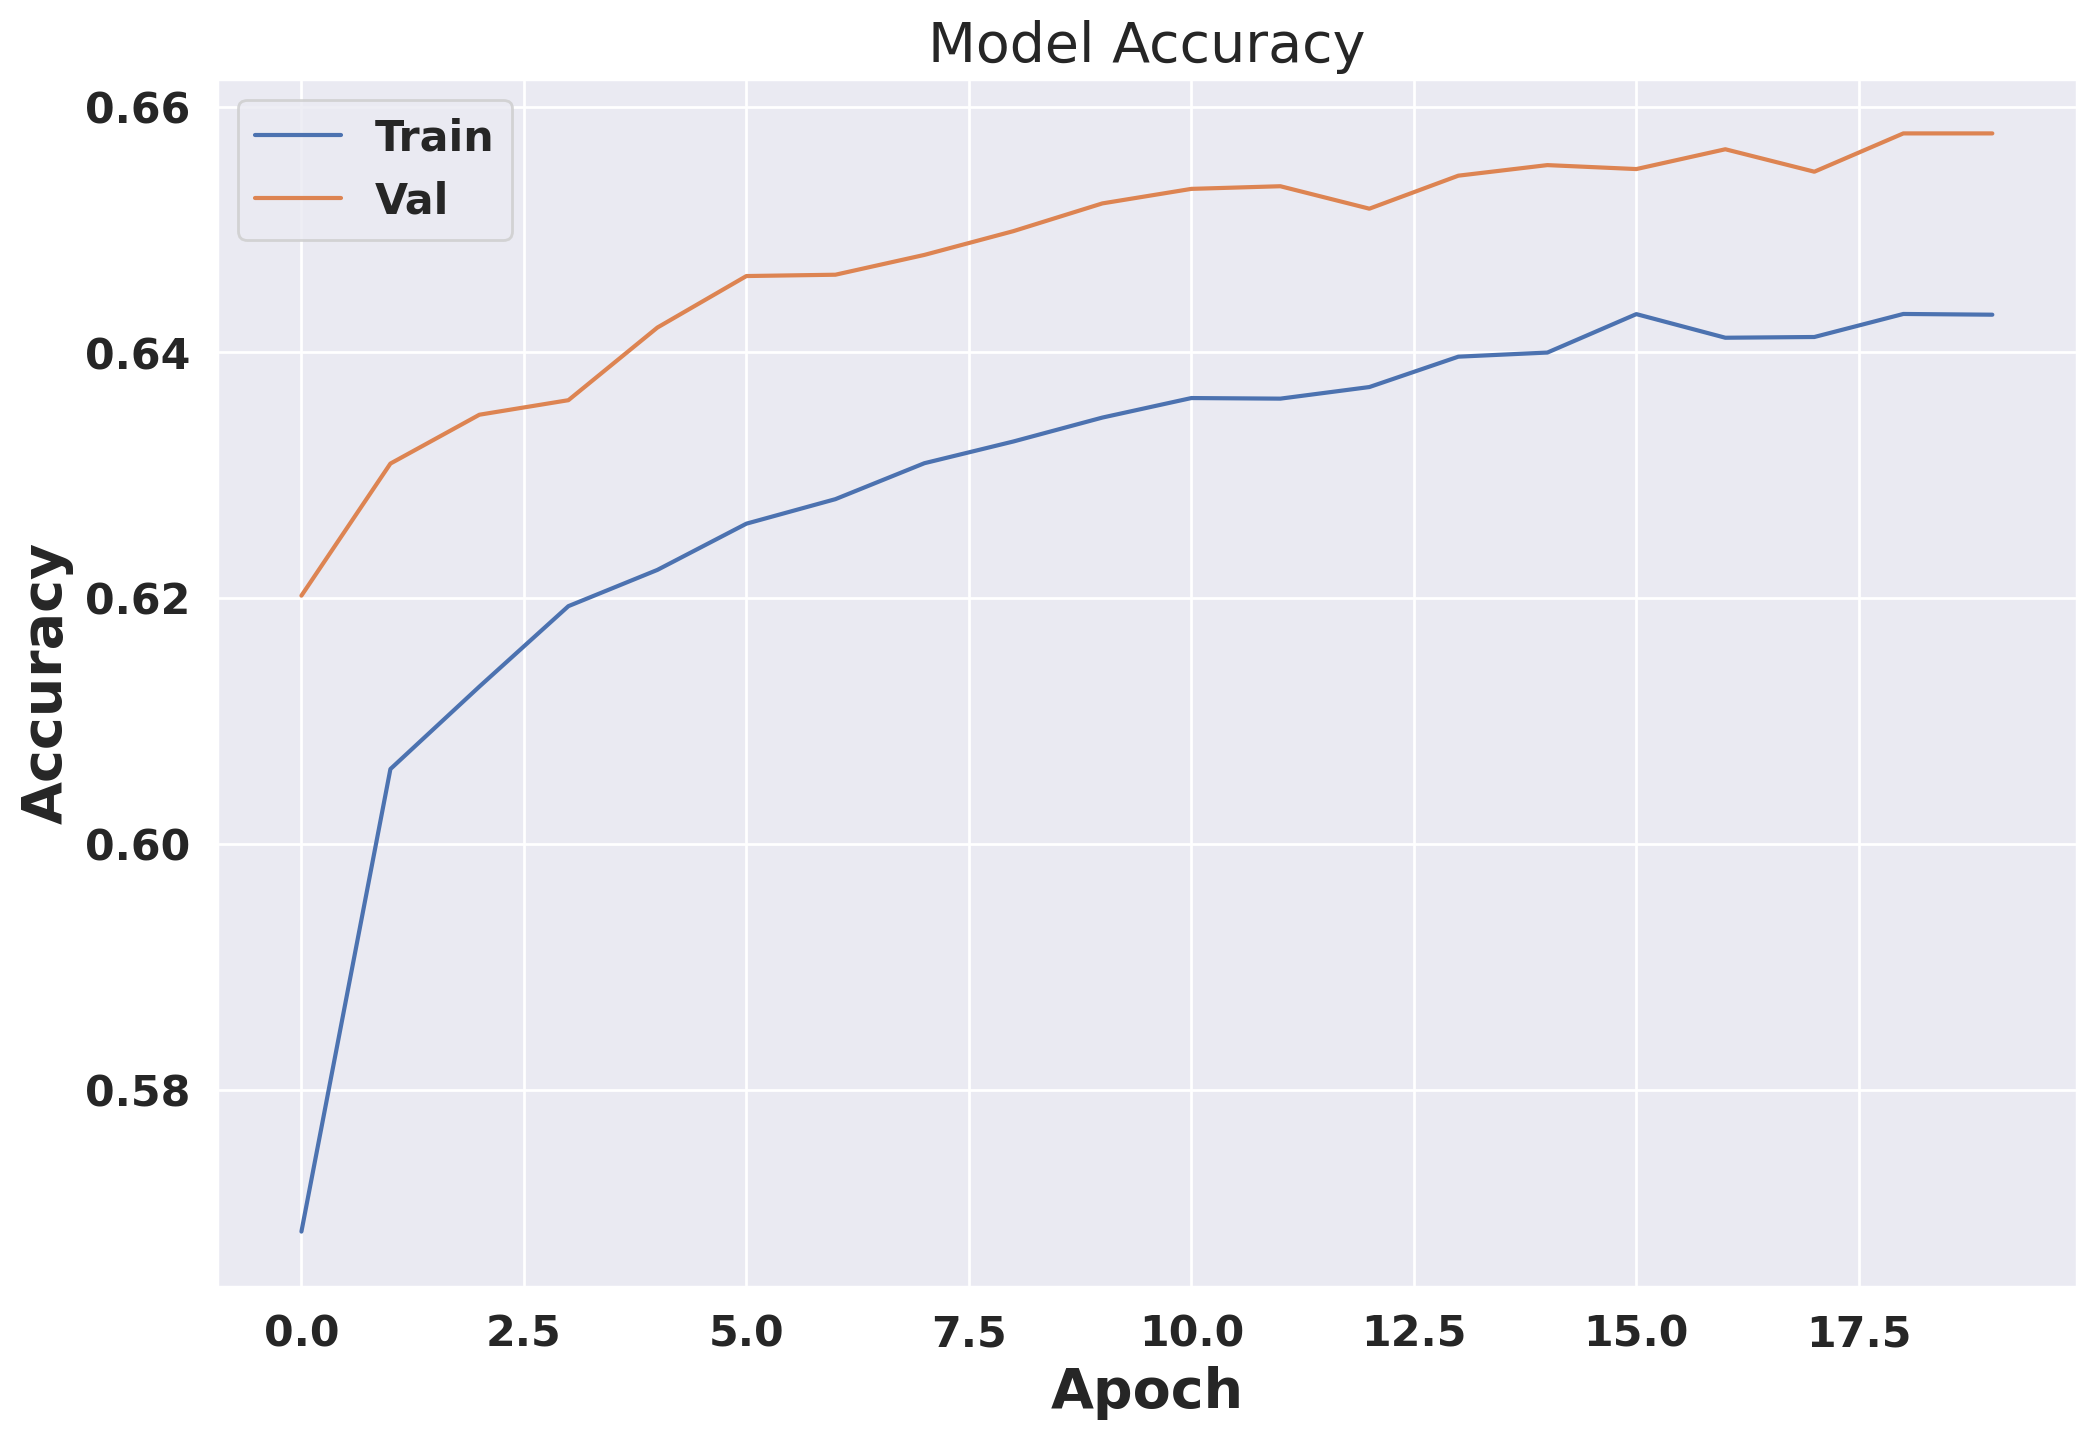

In [97]:
fig = plt.figure(figsize=(12, 8))
fig.set_dpi(200)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Apoch', fontsize=20)
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [98]:
fig.savefig('./acc.png', dpi=1000, bbox_inches='tight')

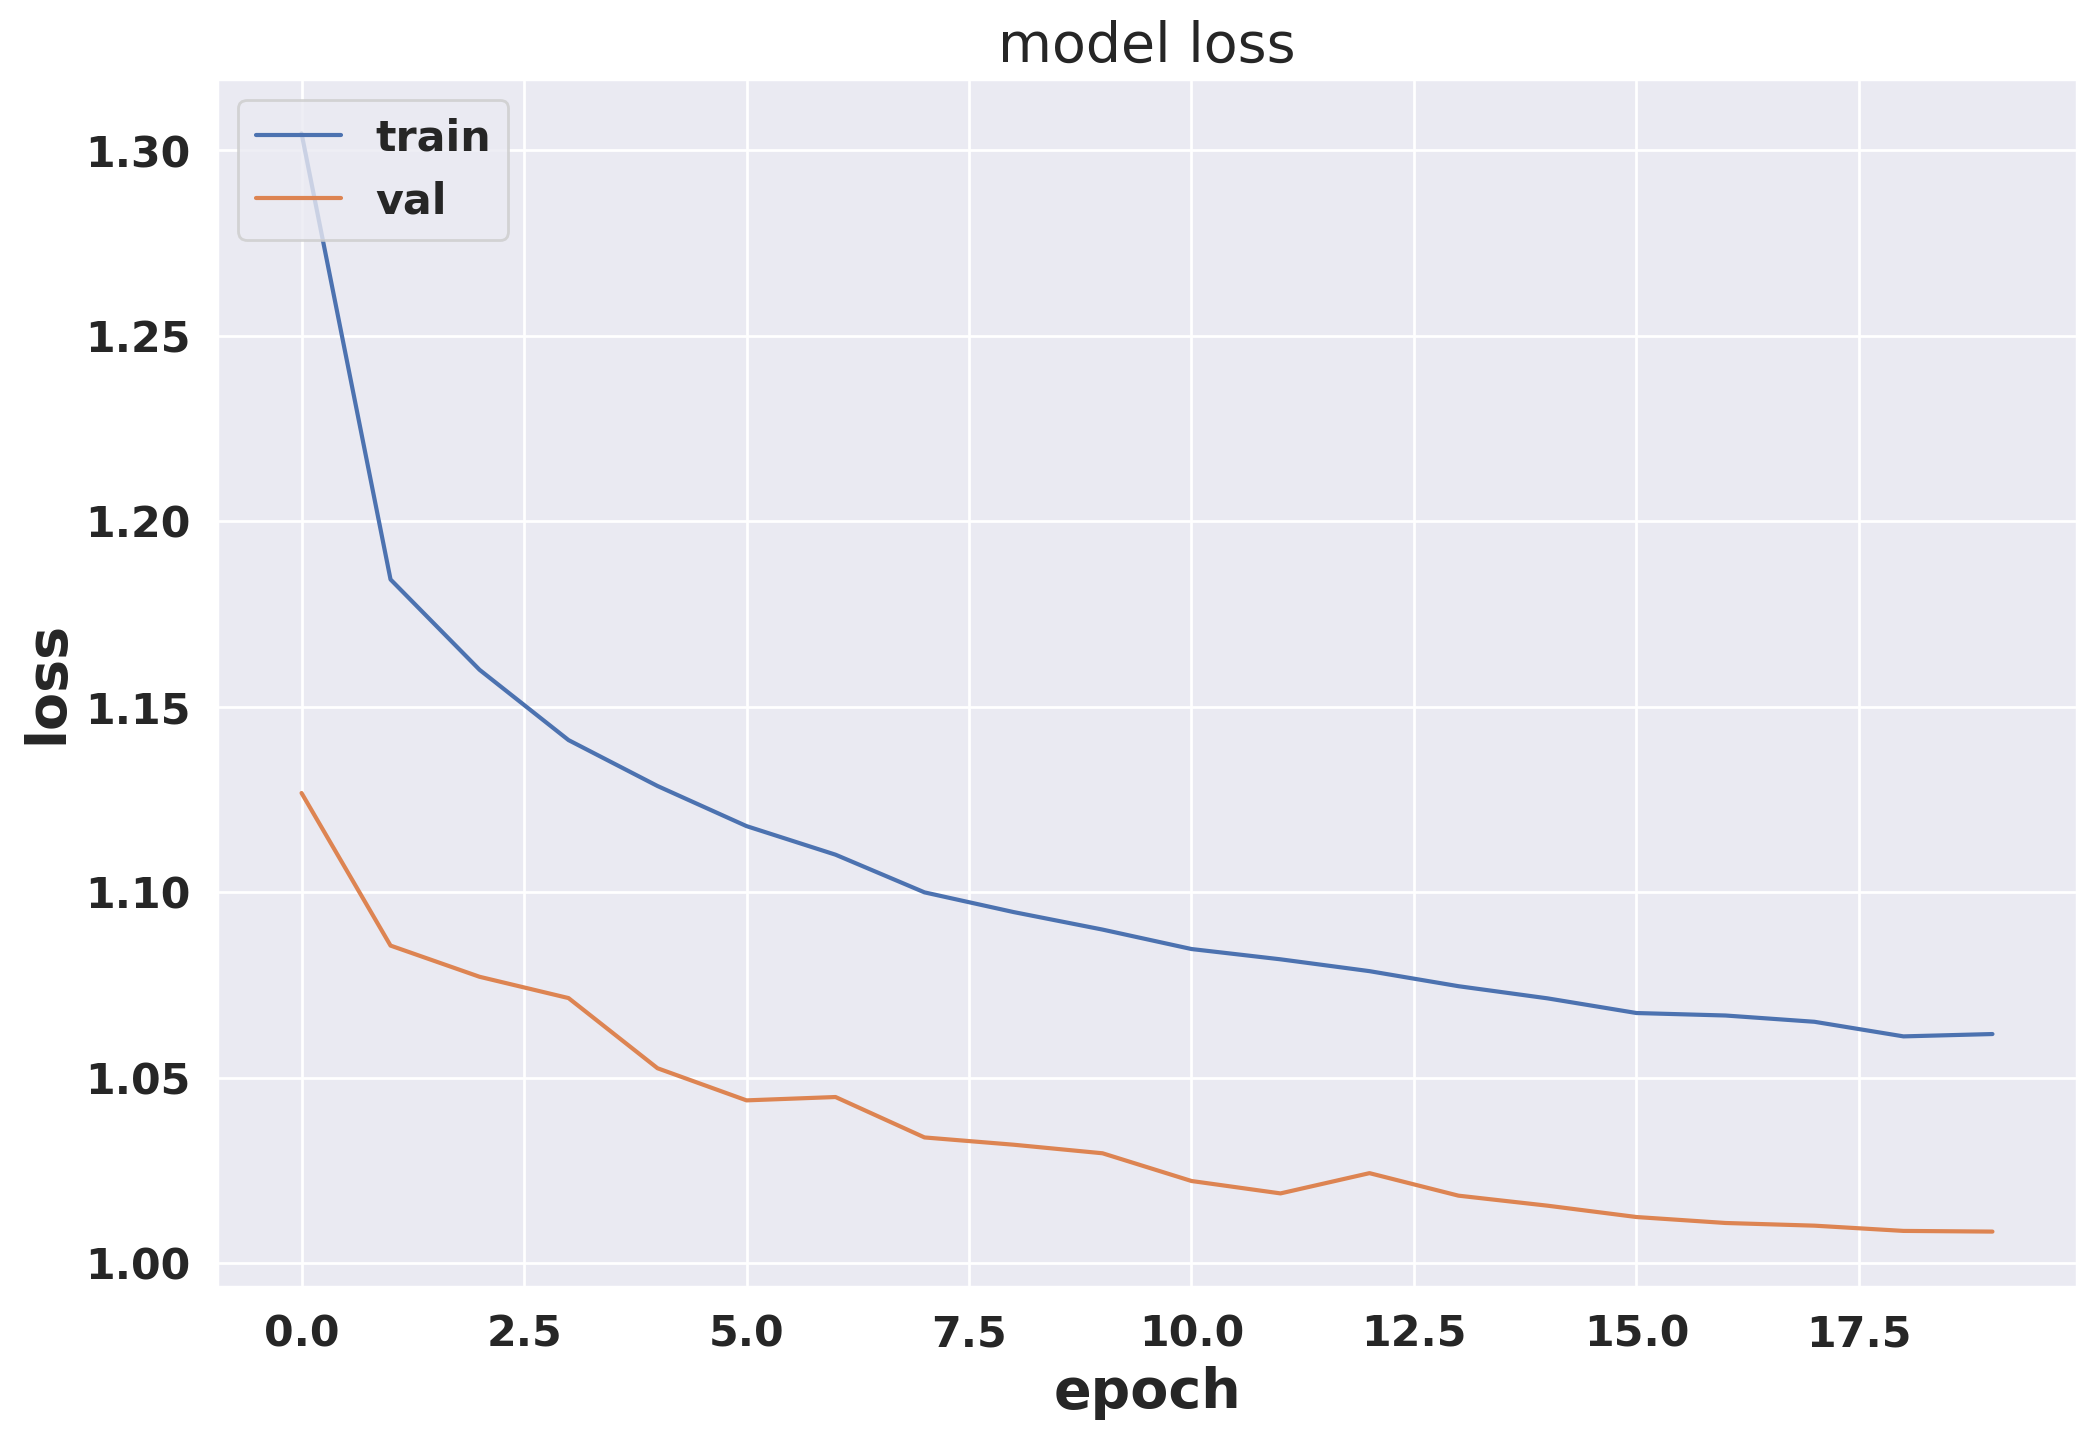

In [99]:
fig = plt.figure(figsize=(12, 8))
fig.set_dpi(200)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [100]:
fig.savefig('./loss.png', dpi=1000, bbox_inches='tight')

In [101]:
y_pred = model.predict([test_features_ids, test_features_masks])
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(test_labels_one_hot, axis=1)

In [102]:
y_pred, y_test

(array([4, 0, 4, ..., 5, 0, 0]), array([5, 0, 5, ..., 5, 0, 0]))

Text(220.49999999999994, 0.5, 'True labels')

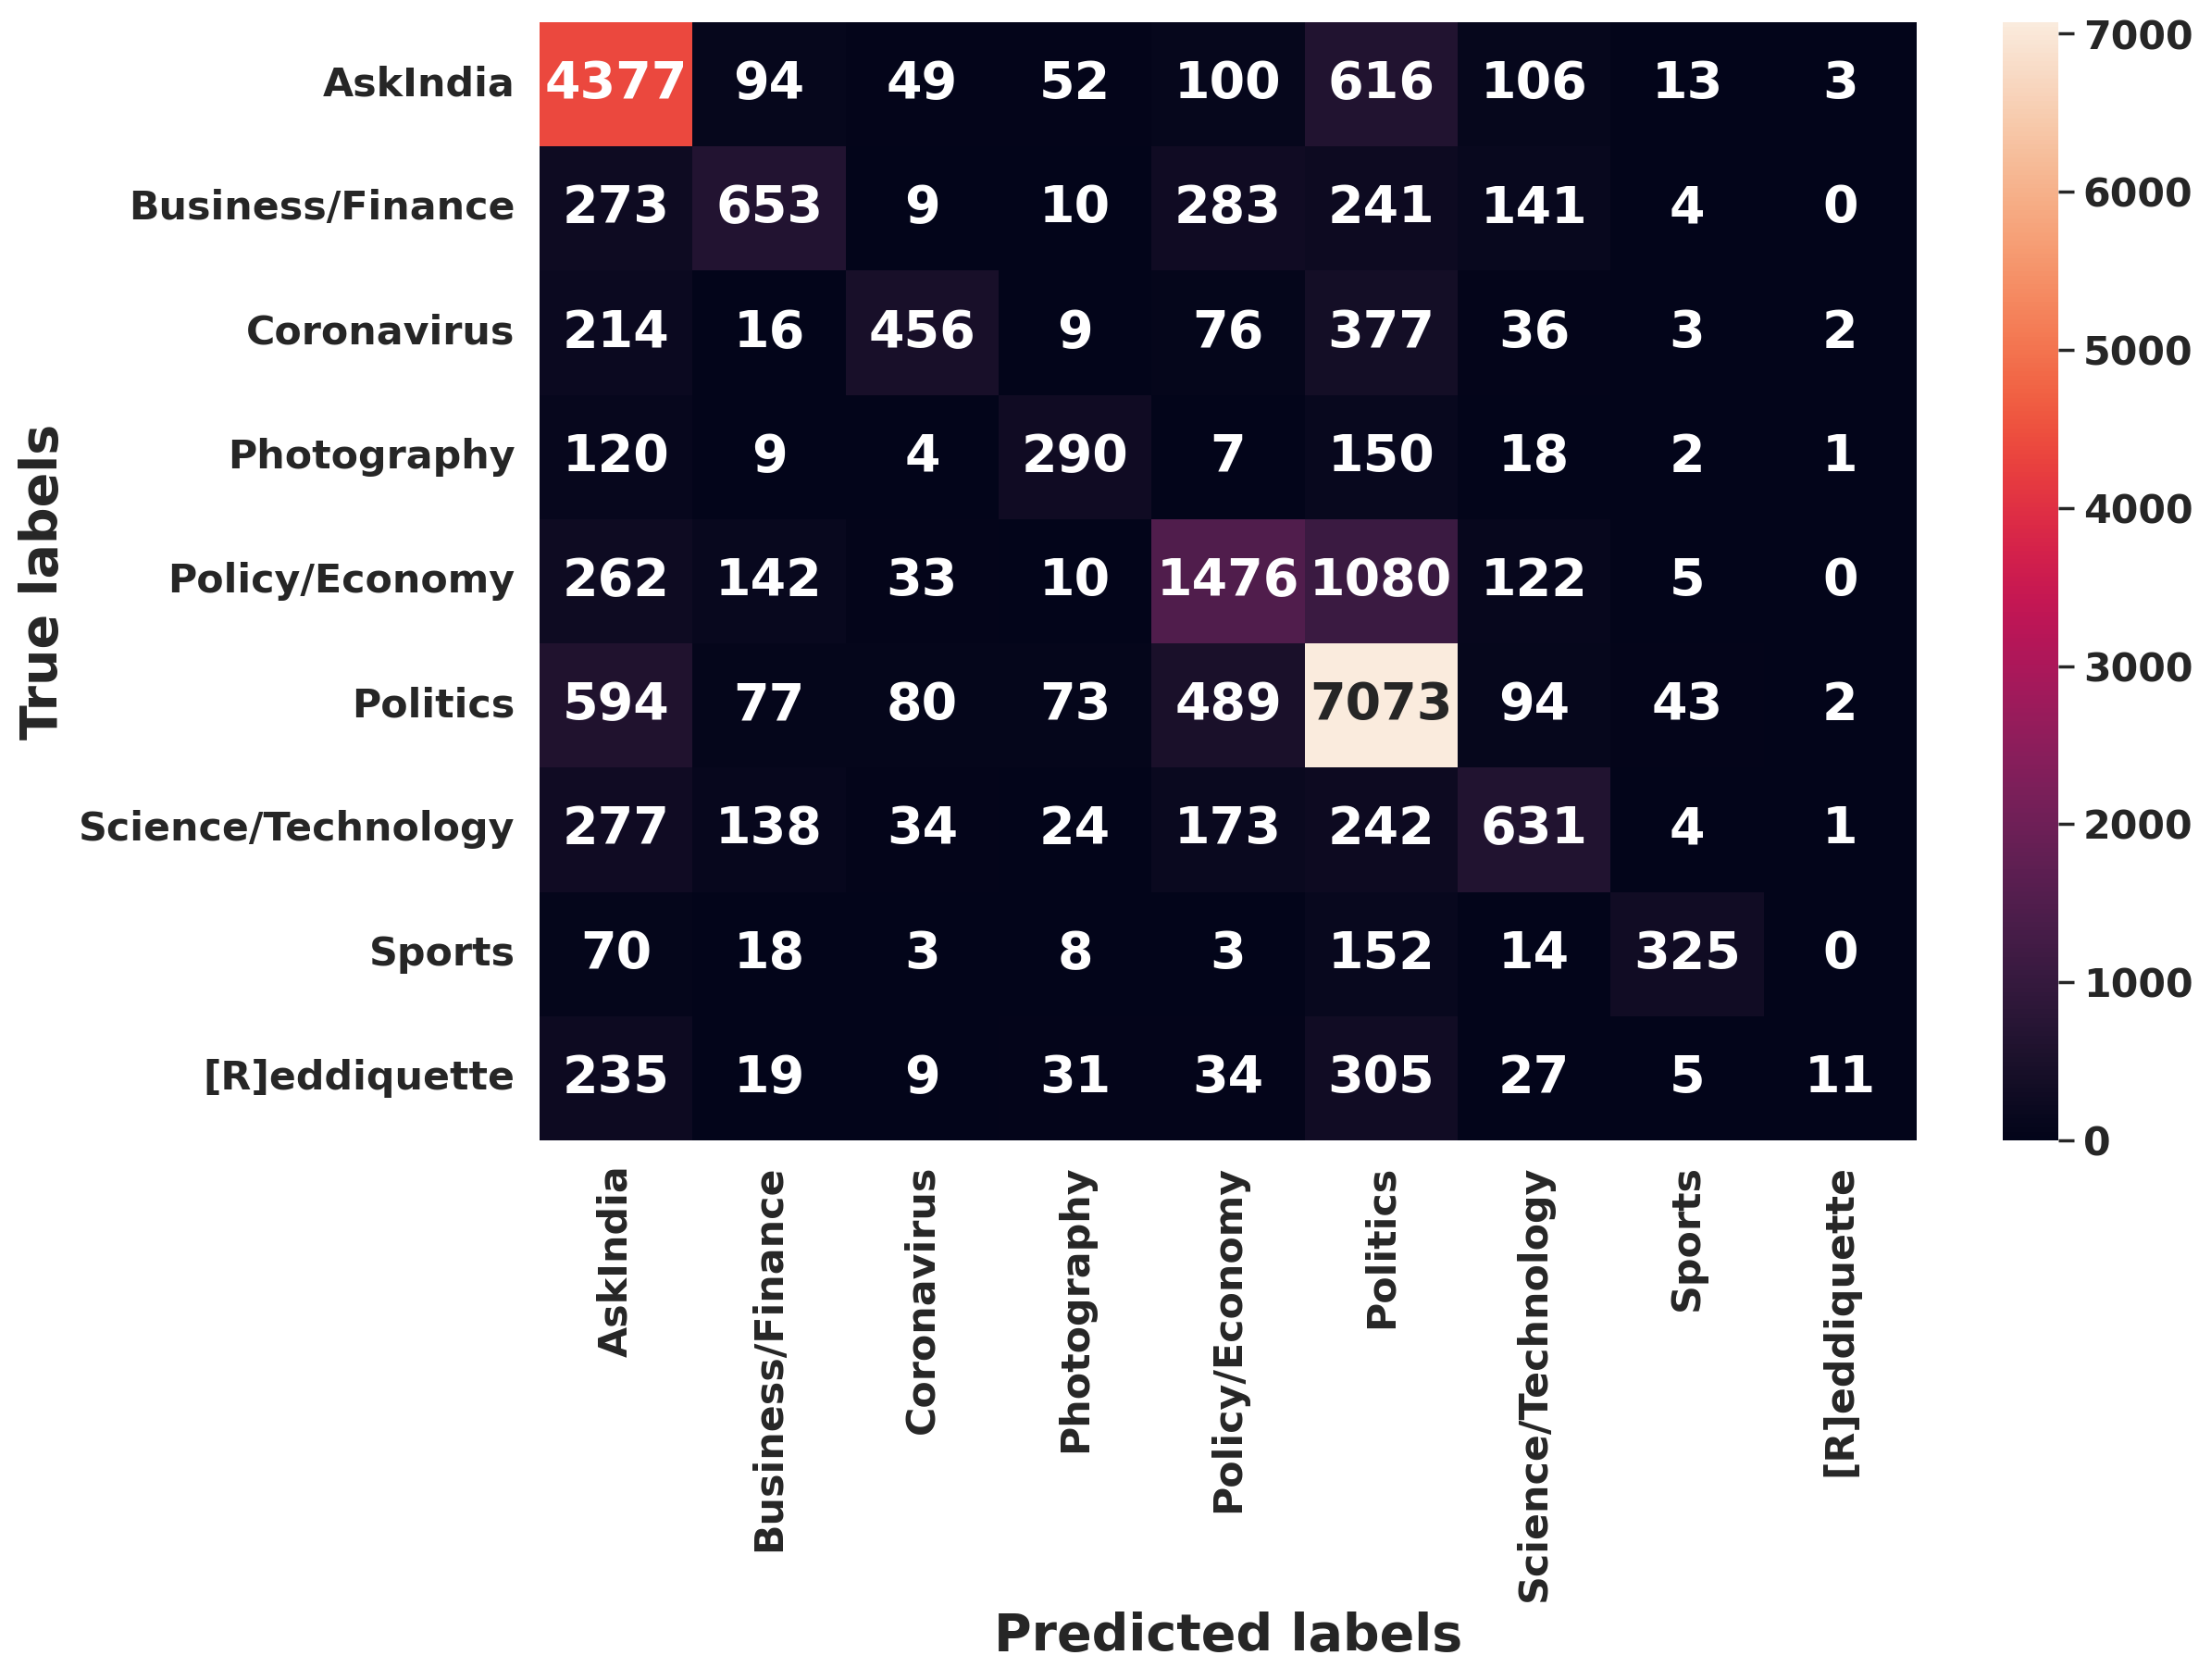

In [103]:
fig = plt.figure(figsize=(12, 8))
fig.set_dpi(200)
sns.set(font_scale=1.4)
ticks = list(enc.categories_[0])
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks, annot_kws={"fontsize":20})
plt.xlabel("Predicted labels", fontsize=20)
plt.ylabel("True labels", fontsize=20)

In [104]:
fig.savefig('./confmatrix.png', dpi=1000, bbox_inches='tight')

<AxesSubplot:>

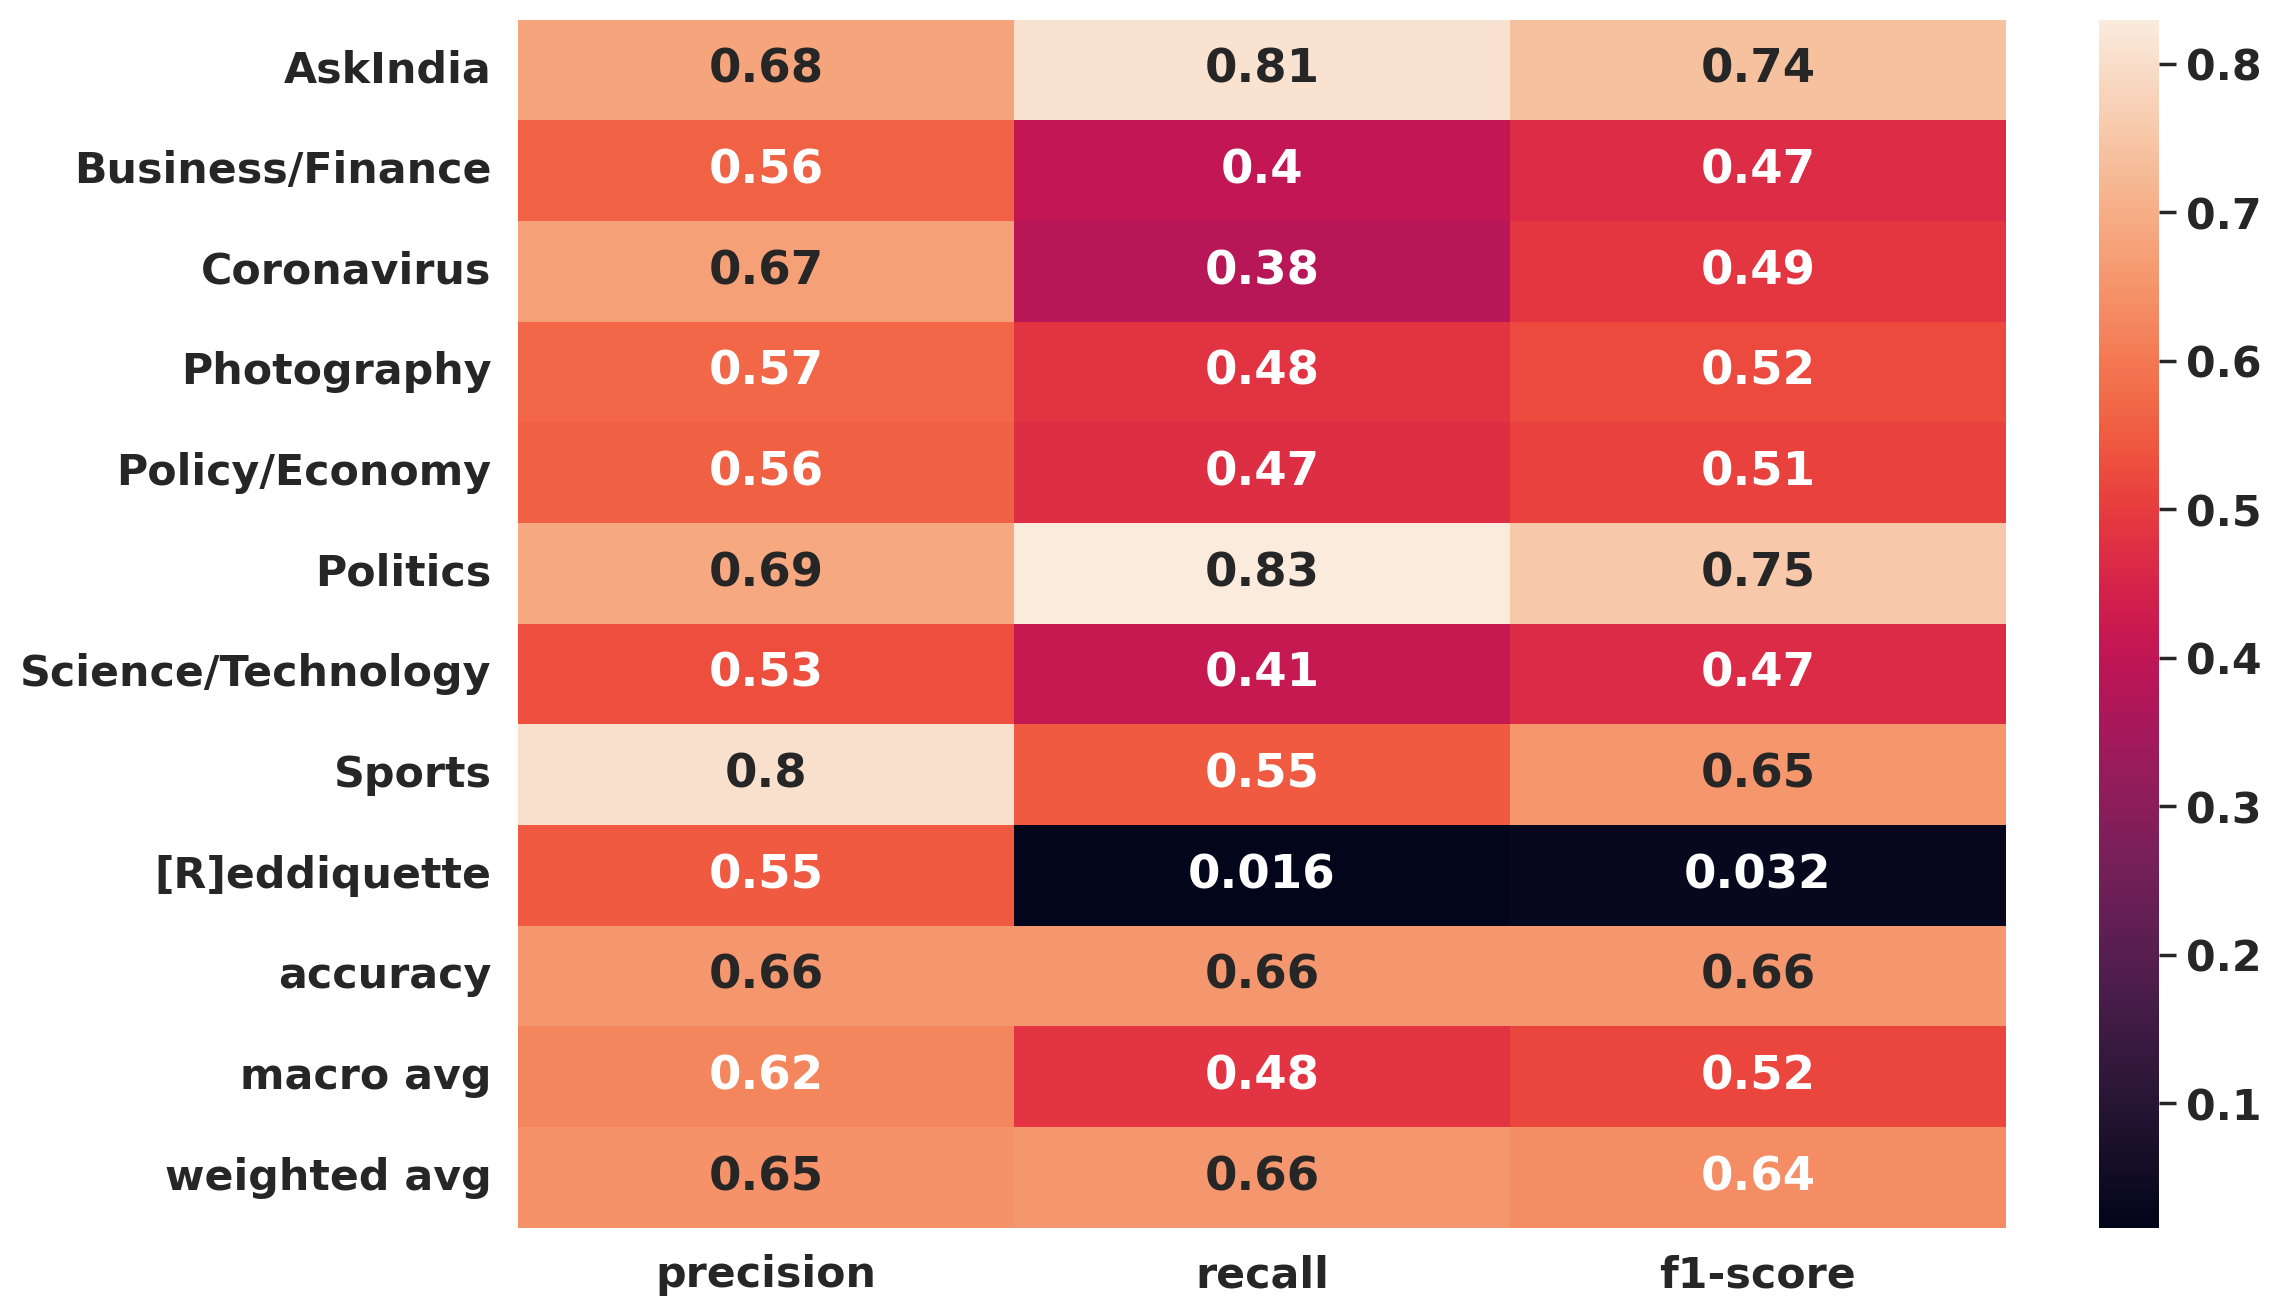

In [105]:
fig = plt.figure(figsize=(12, 8))
fig.set_dpi(200)
report = classification_report(y_test, y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

In [106]:
fig.savefig('./prf1.png', dpi=1000, bbox_inches='tight')